Saving SigCap FMIPA.zip to SigCap FMIPA (14).zip
Total rows loaded: 161
   latitude   longitude  rsrp  rsrq
0 -7.767746  110.377383   -86   -13
1 -7.767839  110.377150   -79   -11
2 -7.767159  110.376771   -74   -12
3 -7.767729  110.377387   -86   -13
4 -7.767143  110.376590   -75   -11


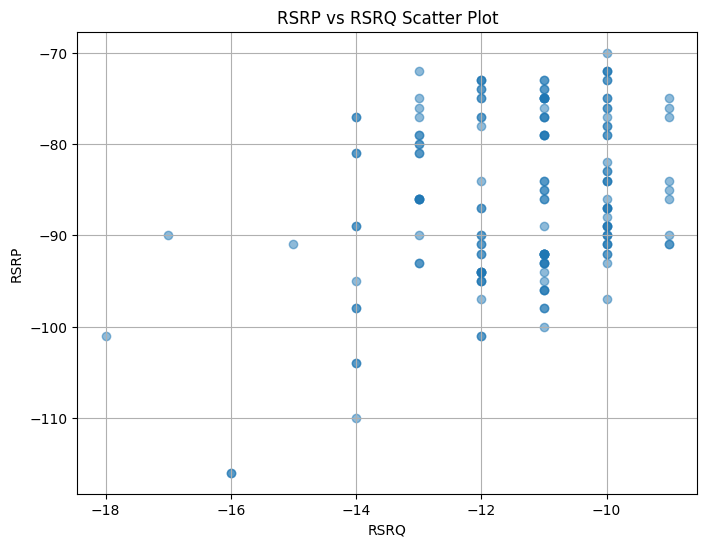

In [24]:
# --- 1. Install dan import library ---
!pip install folium
!pip install geopandas
import zipfile
import json
import pandas as pd
import folium
from folium.plugins import HeatMap
import matplotlib.pyplot as plt
from google.colab import files

# --- 2. Upload ZIP file ---
uploaded = files.upload()
zip_name = list(uploaded.keys())[0]

# --- 3. Extract ZIP ---
with zipfile.ZipFile(zip_name, 'r') as zip_ref:
    zip_ref.extractall("data")

# --- 4. Baca semua file JSON dan ambil lokasi + RSRP/RSRQ ---
import os
df_list = []
folder = "data"
for root, dirs, files_in in os.walk(folder):
    for file in files_in:
        if file.endswith(".txt") or file.endswith(".json"):
            try:
                with open(os.path.join(root, file), "r") as f:
                    data = json.load(f)

                    # Ambil latitude & longitude
                    loc = data.get('location', {})
                    lat = loc.get('latitude', None)
                    lon = loc.get('longitude', None)

                    # Ambil cell_info RSRP & RSRQ
                    cell_info = data.get('cell_info', [])
                    if len(cell_info) > 0:
                        rsrp = cell_info[0].get('rsrp', None)
                        rsrq = cell_info[0].get('rsrq', None)
                    else:
                        rsrp, rsrq = None, None

                    df_list.append({
                        "latitude": lat,
                        "longitude": lon,
                        "rsrp": rsrp,
                        "rsrq": rsrq
                    })
            except:
                # Skip file yang corrupt atau tidak sesuai format
                pass

df = pd.DataFrame(df_list)
print(f"Total rows loaded: {len(df)}")
print(df.head())

# --- 5. Plot Heatmap ---
df_map = df.dropna(subset=['latitude','longitude'])
if len(df_map) == 0:
    print("Tidak ada data lokasi valid untuk heatmap.")
else:
    map_center = [df_map['latitude'].mean(), df_map['longitude'].mean()]
    m = folium.Map(location=map_center, zoom_start=15)
    heat_data = df_map[['latitude','longitude']].values.tolist()
    HeatMap(heat_data).add_to(m)
    display(m)

# --- 6. Scatter plot RSRP vs RSRQ ---
df_signal = df.dropna(subset=['rsrp','rsrq'])
if len(df_signal) == 0:
    print("Tidak ada data RSRP/RSRQ valid untuk plot.")
else:
    plt.figure(figsize=(8,6))
    plt.scatter(df_signal['rsrq'], df_signal['rsrp'], alpha=0.5)
    plt.xlabel("RSRQ")
    plt.ylabel("RSRP")
    plt.title("RSRP vs RSRQ Scatter Plot")
    plt.grid(True)
    plt.show()
